In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
plt.style.use('fivethirtyeight')

## StepByStep in Ch05

In [2]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()

    def to(self, device):
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        def perform_train_step(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        return perform_train_step

    def _make_val_step(self):
        def perform_val_step(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step

    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader == None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # do not find the fastest algorithm
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)
        for epoch in range(n_epochs):
            self.total_epochs += 1
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)
        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train()

    def predict(self, x):
        self.model.eval() 
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        if self.train_loader and self.writer:
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

## Classification: Prepare Data

In [3]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)
print(X.shape, y.shape, X_train.shape, y_train.shape)
print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))

(100, 2) (100,) (80, 2) (80,)
Training:[[-0.0551441  -0.03733246]
 [ 0.82954503 -0.53932149]
 [ 1.66760217 -0.42485665]
 [-0.88230758  0.07249044]
 [-0.59702417  0.6572361 ]] 

Validation:[[ 0.18121142  0.24717743]
 [ 0.20718083 -0.09767143]
 [-0.87539365  0.50543423]
 [ 0.46730819  0.54703192]
 [-1.06964997  0.13666025]]


In [4]:
sc = StandardScaler()
sc.fit(X_train)  # Only fit training set, not validation and test (prevent leak)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))

Training:[[-0.59635346 -0.51713419]
 [ 0.3937561  -1.35813138]
 [ 1.33167696 -1.16636502]
 [-1.52208256 -0.33314461]
 [-1.20280449  0.64649722]] 

Validation:[[-0.33183358 -0.04048629]
 [-0.30276963 -0.61822186]
 [-1.51434476  0.39217903]
 [-0.01164524  0.46186888]
 [-1.73174885 -0.22563902]]


In [5]:
torch.manual_seed(13)
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)
print("{}\n{}".format(train_loader, val_loader))

## Model

In [6]:
# Start from linear regression, value: positive -> 1, negative -> 0
b = -1
w1, w2 = 2, 3
N = 5
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y1 = b + (w1 * x1) + (w2 * x2) + epsilon
results = [1 if num >= 0 else 0 for num in y1]
print("Values of y:")
print(y1)
print("\nLabels:")
print(results)

Values of y:
[[ 0.90060472]
 [ 3.85462306]
 [ 2.6018819 ]
 [ 1.94077544]
 [-0.27704481]]

Labels:
[1, 1, 1, 1, 0]


In [7]:
# Logits: no error term, the value before activation
z = b + (w1 * x1) + (w2 * x2)
print("Values of z:")
print(z)

Values of z:
[[ 0.87270059]
 [ 3.75357153]
 [ 2.65996971]
 [ 1.99329242]
 [-0.2199068 ]]


In [8]:
# Odds Ratio
def odds(prob):
    return prob / (1 - prob)
p = .75
q = 1 - p
print(odds(p), odds(q))

3.0 0.3333333333333333


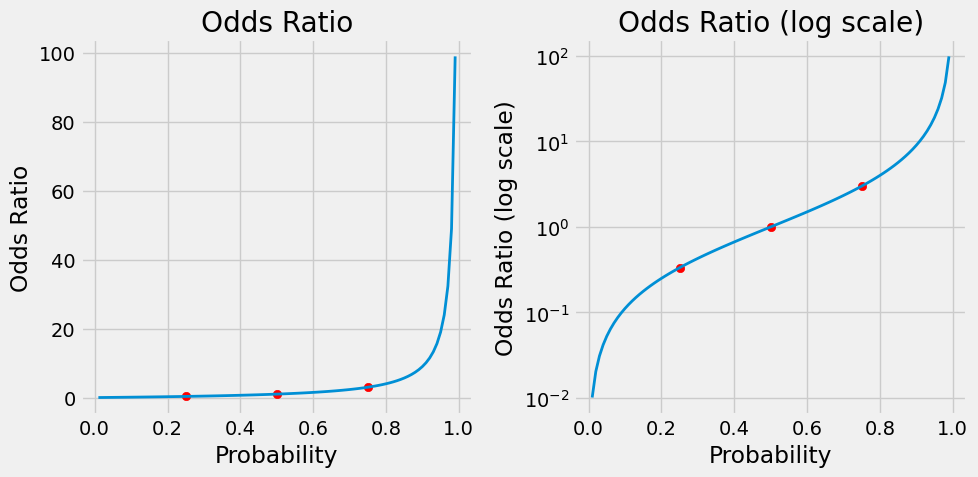

In [9]:
prob1 = 1 / 4
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prob = np.linspace(.01, .99, 99)
for i in [0, 1]:
    ax[i].plot(prob, odds(prob), linewidth=2)
    ax[i].set_xlabel('Probability')
    if i:
        ax[i].set_yscale('log')
        ax[i].set_ylabel('Odds Ratio (log scale)')
        ax[i].set_title('Odds Ratio (log scale)')
    else:
        ax[i].set_ylabel('Odds Ratio')
        ax[i].set_title('Odds Ratio')
    ax[i].scatter([prob1, .5, (1-prob1)], [odds(prob1), odds(.5), odds(1-prob1)], c='r')
fig.tight_layout()

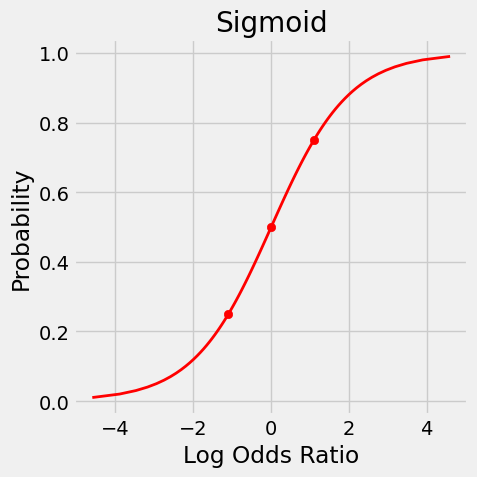

In [10]:
# Sigmoid can be derived from the above right plot
def log_odds(prob):
    return np.log(odds(prob))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
prob = np.linspace(.01, .99, 99)
ax.plot(log_odds(prob), prob, linewidth=2, c='r')
ax.set_ylabel('Probability')
ax.set_xlabel('Log Odds Ratio')
ax.set_title('Sigmoid')
ax.scatter([log_odds(prob1), log_odds(.5), log_odds(1-prob1)], [prob1, .5, (1-prob1)], c='r')
fig.tight_layout()

## Sigmoid function: $z$ is logits
$$
\Large z = \log(\frac{p}{1 - p})\Rightarrow p=\frac{1}{1+e^{-z}} = \sigma(z)
$$

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict({'linear.weight': tensor([[0.5406, 0.5869]]), 'linear.bias': tensor([-0.1657])})


## Loss: BCE (Binary Cross-Entropy)

Define the error as
$$
\Large error_i=\begin{cases}\log(P(y_i=1))&\text{if }y_i=1\\\log(1-P(y_i=1))&\text{if }y_i=0\end{cases}
$$
utilize the fact that $\log(1)=0$ and the error should be zero if the probabilities are correct.  
Note that other log results are negative, which will be handled later.

Therefore, BCE is defined as
$$
\Large
\begin{aligned}
BCE(y)&=-\frac{1}{N_{pos}+N_{neg}}\big[\sum_{i=1}^{N_{pos}}\log(P(y_i=1))+\sum_{i=1}^{N_{neg}}\log(1-P(y_i=1))\big]\\
      &=-\frac{1}{N}\sum_{i=1}^{N}\big[y_i\cdot\log(P(y_i=1))+(1-y_i)\cdot\log(1-P(y_i=1))\big]
\end{aligned}
$$
Negative is necessary so that the BCE value are always non-negative.

In [13]:
# First equation
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
n_total = dummy_labels.size(0)
loss = -(first_summation + second_summation) / n_total
print(loss)

tensor(0.1643)


In [14]:
# Second equation
loss = -torch.sum(dummy_labels * torch.log(dummy_predictions) + (1 - dummy_labels) * torch.log(1 - dummy_predictions)) / n_total
print(loss)

tensor(0.1643)


## BCE in pytorch

- `BCELoss`: inputs are probabilities
  - `reduction`: `mean`, `sum`, and `none`
  - `weight`: default `none` (equal weight)
- `BCEWithLogitsLoss`: inputs are logits (log odd ratio)
  - `reduction`: `mean`, `sum`, and `none`
  - `weight`: default `none` (equal weight)
  - `pos_weight`: set weight for imbalanced dataset, size should be the number of labels (here c = 1)

**IMPORTANT: we should not add a sigmoid as the last layer when using `BCEWithLogitsLoss`**

In [15]:
loss_fn = nn.BCELoss(reduction='mean')
loss = loss_fn(dummy_predictions, dummy_labels)  # predict then label (same as MSELoss)
print(loss)

tensor(0.1643)


In [16]:
logit1 = log_odds(.9)
logit2 = log_odds(.2)
dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
loss = loss_fn(dummy_logits, dummy_labels)
print(loss)

tensor(0.1643)


## Imbalanced Dataset
$$\Large\text{pos\_weight} = \frac{\text{\# of negative class}}{\text{\# of positive class}}$$

In [17]:
logit1 = log_odds(.9)
logit2 = log_odds(.2)
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()
pos_weight = (n_neg / n_pos).view(1,)
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
print(loss)  # Not 0.1643 since pos_weight is not multiplied in denominator

tensor(0.2464)


In [18]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)
loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)
print(loss)

tensor([0.1643])


## Train Model

In [19]:
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

In [20]:
n_epochs = 100
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[ 1.1806, -1.8693]], device='cuda:0'), 'linear.bias': tensor([-0.0591], device='cuda:0')})


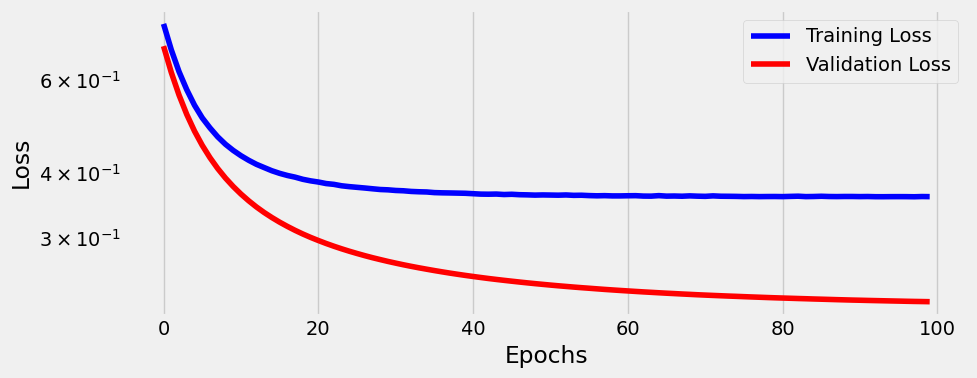

In [21]:
fig = sbs.plot_losses()

In [22]:
predictions = sbs.predict(x_train_tensor[:4])
print(predictions)  # outputs are logits

[[ 0.20345594]
 [ 2.9444456 ]
 [ 3.693318  ]
 [-1.2334074 ]]


In [23]:
probabilities = sigmoid(predictions)
print(probabilities)

[[0.5506892]
 [0.9500003]
 [0.9757152]
 [0.2255856]]


In [24]:
classes = (predictions >= 0).astype(int)
print(classes)

[[1]
 [1]
 [1]
 [0]]


## Decision Boundary

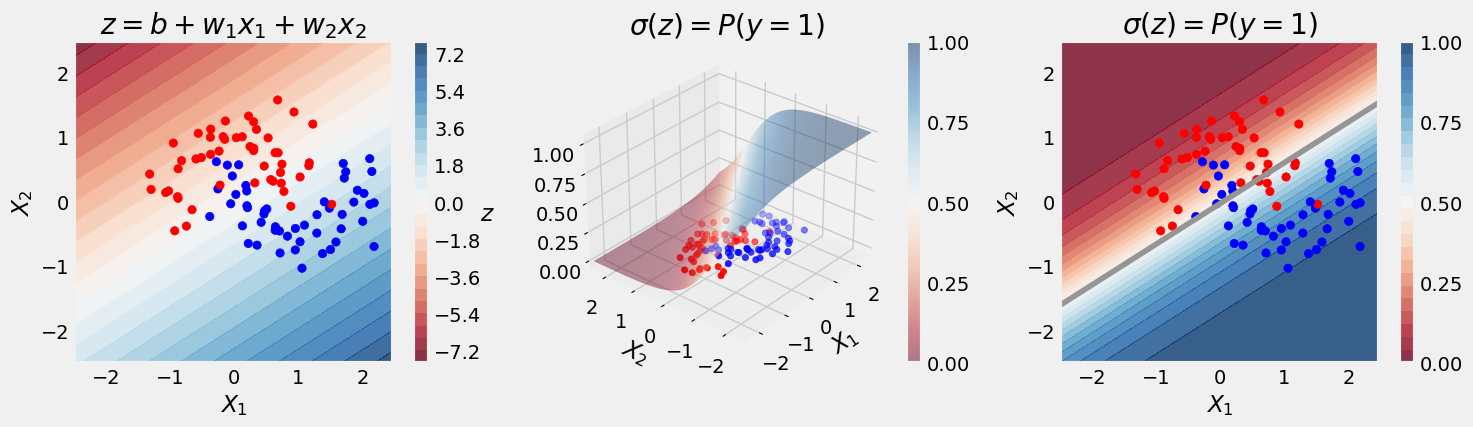

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig = plt.figure(figsize=(15, 4.5))

h = .02   
x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
logits = logits.detach().cpu().numpy().reshape(xx.shape)

yhat = sigmoid(logits)

# 1st plot
ax = plt.subplot(1, 3, 1)
contour = ax.contourf(xx, yy, logits, 25, cmap=cm, alpha=.8)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_title(r'$z = b + w_1x_1 + w_2x_2$')
ax.grid(False)
ax_c = plt.colorbar(contour)
ax_c.set_label("$z$", rotation=0)

# 2nd plot
ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(xx, yy, yhat, rstride=1, cstride=1, alpha=.5, cmap=cm, linewidth=0, antialiased=True, vmin=0, vmax=1)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_title(r'$\sigma(z) = P(y=1)$')
ax_c = plt.colorbar(surf)
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.view_init(30, 220)

# 3rd plot
ax = plt.subplot(1, 3, 3)
ax.contour(xx, yy, yhat, levels=[.5], cmap="Greys", vmin=0, vmax=1)
contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_title(r'$\sigma(z) = P(y=1)$')
ax.grid(False)
ax_c = plt.colorbar(contour)
ax_c.set_ticks([0, .25, .5, .75, 1])
plt.tight_layout()

In [28]:
# We may increase dimensions to solve the problem
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())
loss_fn = nn.BCELoss()
print(model)

Sequential(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [37]:
def split_cm(cm):
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]   
    return tn, fp, fn, tp
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
print(cm_thresh50)
print(split_cm(cm_thresh50))

[[ 7  2]
 [ 1 10]]
(7, 2, 1, 10)


In [110]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    tpr = tp / (tp + fn)  # Recall
    fpr = fp / (fp + tn)
    return tpr, fpr

def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    if (tp + fp == 0):
        precision = 1
    else:
        precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

# Drawback of accuracy: no trade-off metric to compare
def calculate_accuracy(cm):
    tn, fp, fn, tp = split_cm(cm)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

## Reciever Operating Characteristic (ROC) Curve and Precision-Recall (PR) Curve

In [114]:
def eval_curves_from_probs(y, probabilities, threshs, line=False, annot=False):
    cms = [confusion_matrix(y, (probabilities >= threshold)) for threshold in threshs]
    rates = np.array(list(map(tpr_fpr, cms)))
    precrec = np.array(list(map(precision_recall, cms)))
    return eval_curves(rates[:, 1], rates[:, 0], precrec[:, 1], precrec[:, 0], threshs, line=line, annot=annot)    

def eval_curves(fprs, tprs, recalls, precisions, thresholds, thresholds2=None, line=False, annot=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if thresholds2 is None:
        thresholds2 = thresholds[:]

    marker = '.r-' if line else '.r'

    axs[0].plot(fprs, tprs, marker, markersize=12, linewidth=2)
    axs[0].set_xlim([-.05, 1.05])
    axs[0].set_ylim([-.05, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')

    axs[1].plot(recalls, precisions, marker, markersize=12, linewidth=2)
    axs[1].set_xlim([-.05, 1.05])
    axs[1].set_ylim([-.05, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    
    if annot:
        for thresh, fpr, tpr, prec, rec in zip(thresholds, fprs, tprs, precisions, recalls):
            axs[0].annotate(str(thresh), xy=(fpr - .03, tpr - .07))

        for thresh, fpr, tpr, prec, rec in zip(thresholds2, fprs, tprs, precisions, recalls):
            axs[1].annotate(str(thresh), xy=(rec - .03, prec - .07))

    fig.tight_layout()
    return fig

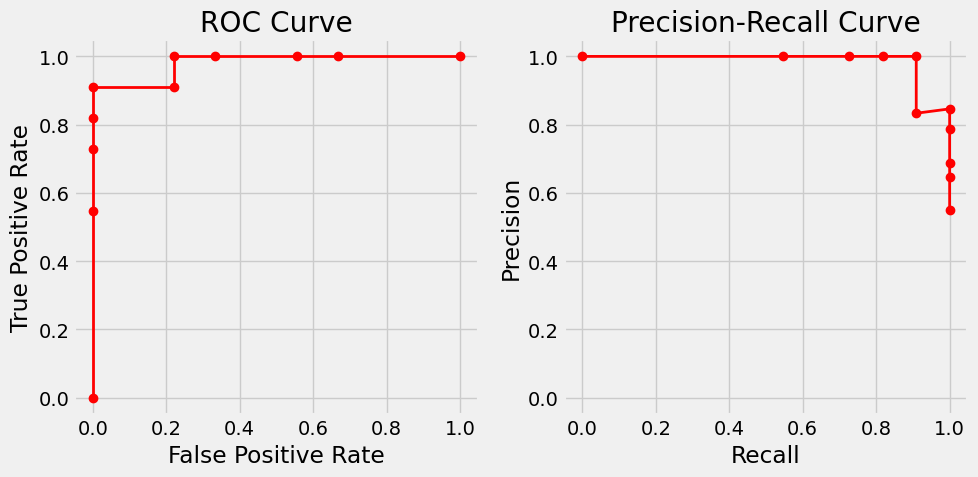

In [115]:
# Manual compute curves
probs = np.linspace(0, 1, 11)
probabilities_val = sigmoid(sbs.predict(X_val)).squeeze()
fig = eval_curves_from_probs(y_val, probabilities_val, probs, line=True)

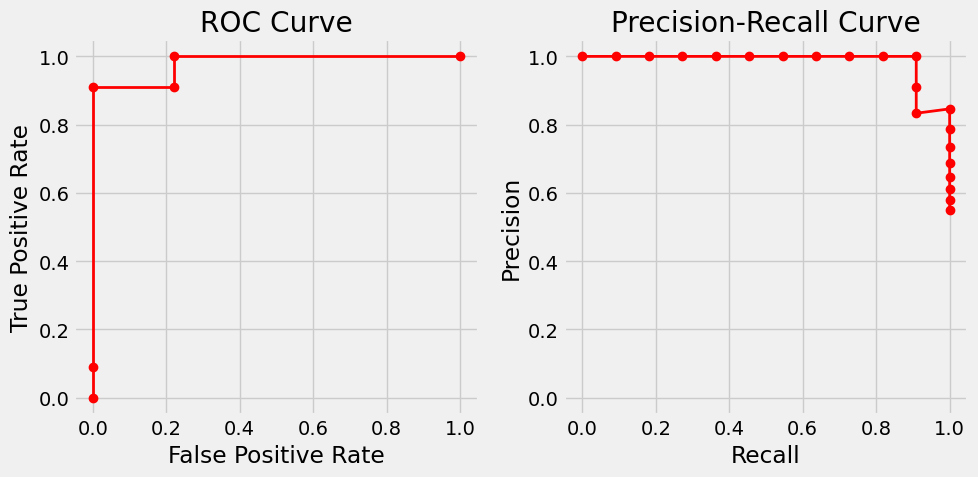

In [123]:
# Sklearn compute curves and thresholds
probabilities_val = sigmoid(sbs.predict(X_val)).squeeze()
fpr, tpr, threshold1 = roc_curve(y_val, probabilities_val)
prec, rec, threshold2 = precision_recall_curve(y_val, probabilities_val)
fig = eval_curves(fpr, tpr, rec, prec, threshold1, threshold2, True)

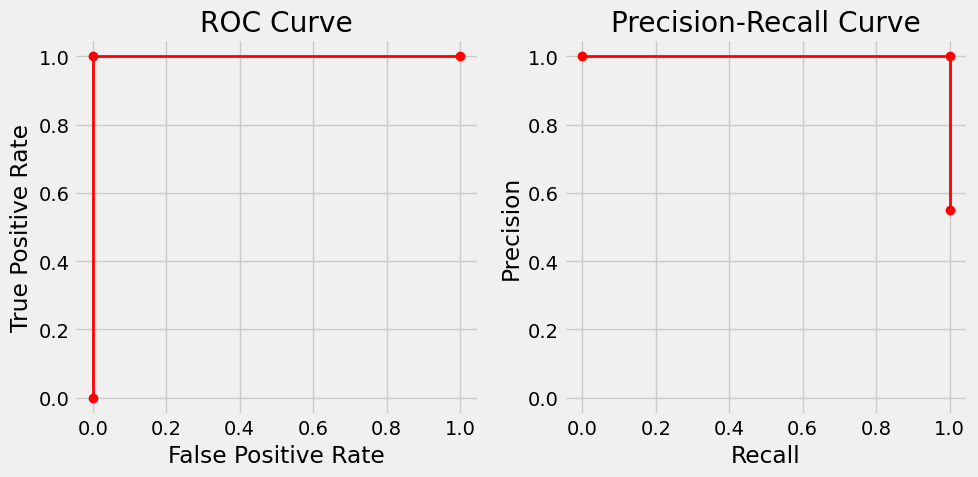

In [124]:
# Best curves
fpr, tpr, threshold1 = roc_curve(y_val, y_val)
prec, rec, threshold2 = precision_recall_curve(y_val, y_val)
fig = eval_curves(fpr, tpr, rec, prec, threshold1, threshold2, True)

## Aera Under the Curve (AUC)

In [125]:
probabilities_val = sigmoid(sbs.predict(X_val)).squeeze()
fpr, tpr, threshold1 = roc_curve(y_val, probabilities_val)
prec, rec, threshold2 = precision_recall_curve(y_val, probabilities_val)
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356
